In [1]:
from mucstpy.utils import *
from mucstpy.image_feature import ImageFeature, image_crop
from pathlib import Path

os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


### Change the data path to your dir_path here

In [2]:
adata = read_10x_visium(path='D:/st_projects/data/IDC')
adata.var_names_make_unique()
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata = adata[:, adata.var['total_counts'] > 100]
adata.raw = adata

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=False, max_value=10)

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\anndata\_core\anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
section = 'IDC'
save_path = 'results'
save_path_image_crop = Path(os.path.join(save_path, 'image_crop', f'{section}'))
save_path_image_crop.mkdir(parents=True, exist_ok=True)

adata = image_crop(adata, crop_size=112, save_path=save_path_image_crop, verbose=False)
adata = ImageFeature(adata, pca_components=200, verbose=True, seeds=2023).extract_image_features()
adata

Tiling Image: 100%|██████████ [ time left: 00:00 ]
Extract image feature: 100%|██████████ [ time left: 00:00 ]


The image feature is added to adata.obsm['Image_Feature']
The pca result of image features is added to adata.obsm['image_feat_pca']


AnnData object with n_obs × n_vars = 4727 × 13126
    obs: 'in_tissue', 'array_row', 'array_col', 'image_col', 'image_row', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'slice_path'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_cells', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'image_feature', 'aug_image_feature1', 'aug_image_feature2', 'image_feat_pca'

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


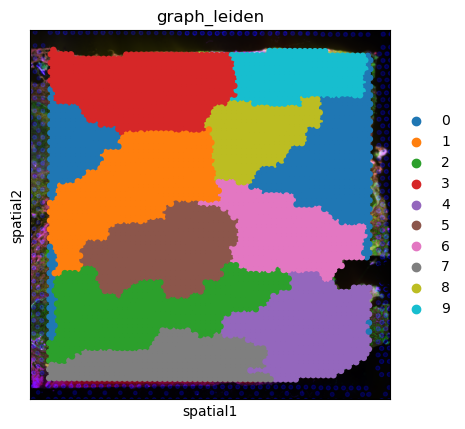

In [4]:
sc.pp.neighbors(adata, use_rep='image_feat_pca')
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added='graph_leiden', resolution=0.2)
sc.pl.spatial(adata, color=['graph_leiden'], size=2)

In [5]:
from sklearn.metrics import pairwise_distances
from mucstpy.utils import construction_interaction

construction_interaction(adata, n_neighbor=6)
adj = adata.obsm['adj']

morphological_similarity = 1 - pairwise_distances(np.array(adata.obsm['image_feat_pca']), metric='cosine')
morphological_similarity[morphological_similarity < 0] = 0

adj_spatial_mor = adj * morphological_similarity
adata.obsm['mor_adj'] = adj_spatial_mor

In [6]:
from mucstpy.utils import data_augmentation

data_augmentation(adata, aug_para=0.2)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [8]:
add_contrastive_label(adata)
get_feature(adata)

### For different, we set different relative importance to the morphology modality

In [9]:
from mucstpy.MuCST import train_model

gene_dims=[adata.shape[1], 64]
img_dims=[adata.obsm['image_feature'].shape[1], 64]
project_dims=[64, 32, 16]

train_model(adata, gene_dims=gene_dims, img_dims=img_dims, proj_dims=project_dims, lamb1=0.3, lamb3=0.2, device=device)

Begin to train MuCST...


# Epoch 1499, loss: 0.993, g2g_loss: 0.404, gene_recon: 0.950, image_recon: 0.007:  97%|█████████▋| 1497/1550 [00:48<00:01, 31.24it/s]

# Epoch 1500, loss: 14.068, g2g_loss: 0.403, gene_recon: 0.950, image_recon: 0.007
Init finished, start contrastive learning part


# Epoch 1549, loss: 11.944, g2i_loss: 8.926, g2g_loss: 0.497, i2i_loss: 9.149, gene_recon: 0.956, image_recon: 0.014: 100%|██████████| 1550/1550 [02:24<00:00, 10.73it/s] 


Optimization of MuCST finished


fitting ...
  |======================================================================| 100%


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


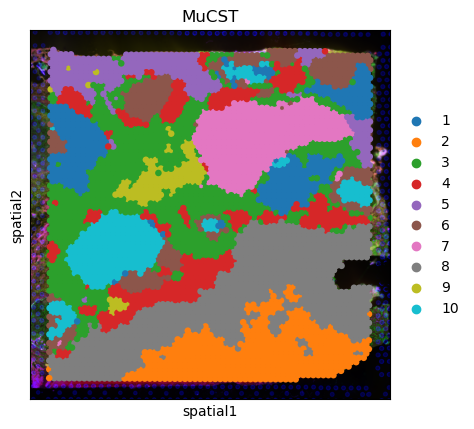

In [12]:
from mucstpy.utils import mclust_R
import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-4.3.1'

tool = 'mclust'

mclust_R(adata, used_obsm='fusion_pca', num_cluster=10)
sc.pl.spatial(adata, color=['mclust'], title=['MuCST'], size=2)

In [13]:
sc.pp.neighbors(adata, use_rep='fusion_pca')
sc.tl.umap(adata)

In [14]:
sc.tl.leiden(adata, key_added='mucst_leiden', resolution=0.4)
adata.obs['mucst_leiden']

AAACAAGTATCTCCCA-1    8
AAACAATCTACTAGCA-1    4
AAACACCAATAACTGC-1    1
AAACAGAGCGACTCCT-1    4
AAACAGCTTTCAGAAG-1    1
                     ..
TTGTTTCACATCCAGG-1    1
TTGTTTCATTAGTCTA-1    2
TTGTTTCCATACAACT-1    1
TTGTTTGTATTACACG-1    2
TTGTTTGTGTAAATTC-1    4
Name: mucst_leiden, Length: 4727, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


C:\ProgramData\anaconda3\envs\gpudeepl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


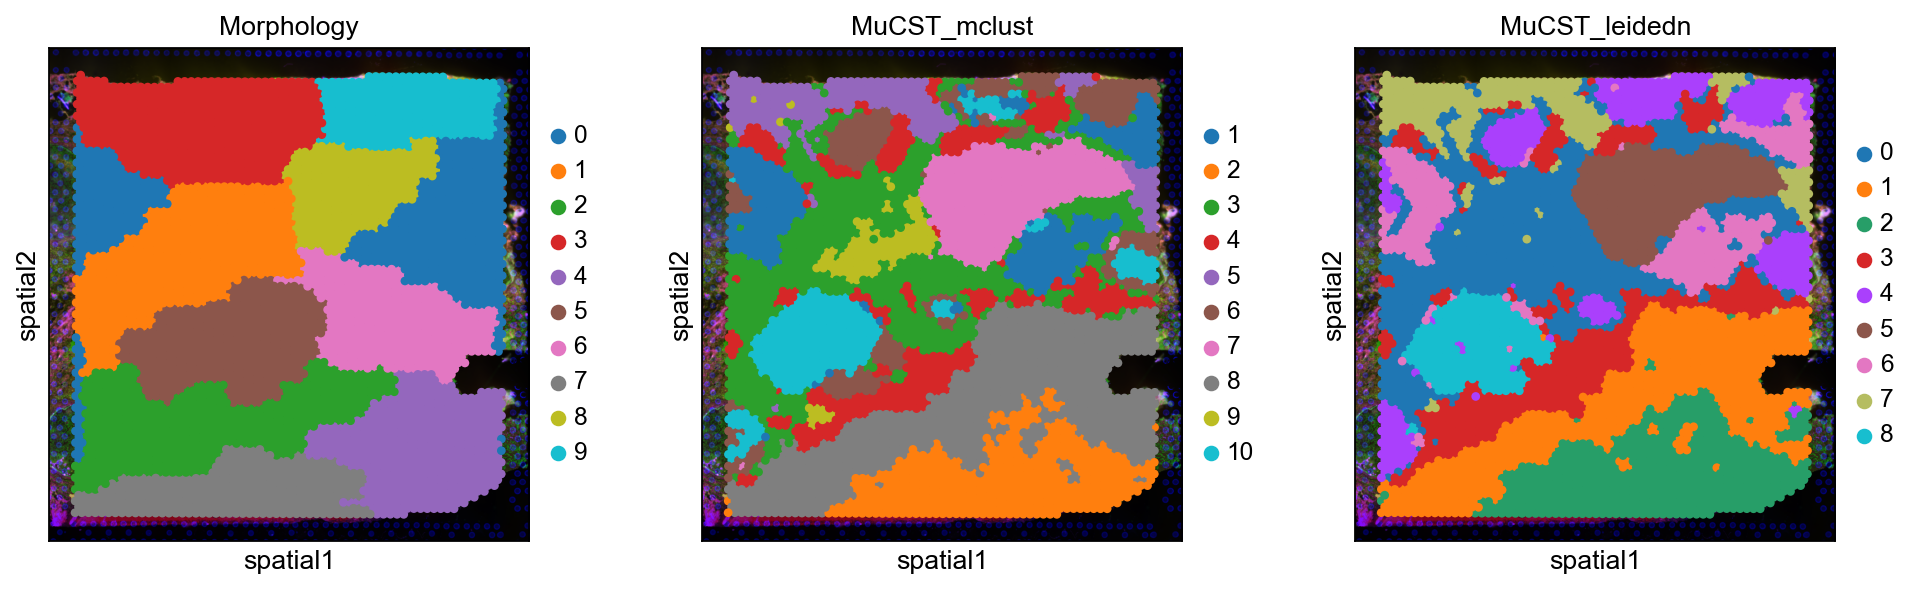

In [17]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=200, frameon=True, vector_friendly=False, fontsize=12, figsize=None, color_map=None, format='eps', facecolor=None, transparent=True, ipython_format='png2x')

# sc.pl.spatial(adata, color=['domain'], title=['MuCST'], size=2)
sc.pl.spatial(adata, color=['graph_leiden', 'mclust', 'mucst_leiden'], title=['Morphology', 'MuCST_mclust', 'MuCST_leidedn'], size=2, save='MuCST_IDC')